# RFSoC RF-DC Frequency Planner

In [1]:
import numpy as np
from ipywidgets import widgets
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # garbage collection should close plots when finished so safe to supress this warning
# %matplotlib widget

## RF-ADC

In [105]:
class FrequencyPlannerADC:

    def __init__(self, fs_rf=4092, fc=1175.42, fs_bw=10.23, pll_ref=409.2, il_factor=8):
        self.fs_rf = fs_rf
        self.fc = fc
        self.fs_bw = fs_bw
        self.pll_ref = pll_ref
        self.il_factor = il_factor
        
        self.f = np.linspace(-0.5,0.5,101)
        
    @property
    def signal_f(self):
        fs_rf = self.fs_rf
        fs_bw = self.fs_bw
        fc = self.fc
        f = self.f
        
        return [fs_rf - ((fc+fs_bw*i) % fs_rf) if ((fc+fs_bw*i) % fs_rf) >= fs_rf/2 else ((fc+fs_bw*i) % fs_rf) for i in f]

    @property
    def interf_f(self):
        fc = self.fc
        fs_bw = self.fs_bw
        f = self.f
        return [fc+(fs_bw*i) for i in f]
    
    @property    
    def hd(self):
        fs_rf = self.fs_rf
        interf_f = self.interf_f
        
        hd2 = [fs_rf - (2*i % fs_rf) if 2*i % fs_rf >= fs_rf/2 else (2*i % fs_rf) for i in interf_f]
        hd3 = [fs_rf - (3*i % fs_rf) if 3*i % fs_rf >= fs_rf/2 else (3*i % fs_rf) for i in interf_f]
        hd4 = [fs_rf - (4*i % fs_rf) if 4*i % fs_rf >= fs_rf/2 else (4*i % fs_rf) for i in interf_f]
        hd5 = [fs_rf - (5*i % fs_rf) if 5*i % fs_rf >= fs_rf/2 else (5*i % fs_rf) for i in interf_f]
        
        return hd2, hd3, hd4, hd5
    
    @property
    def il(self):
        fs_rf = self.fs_rf
        signal_f = self.signal_f
        interf_f = self.interf_f
        il_factor = self.il_factor
        
        if il_factor > 1:
            il1 = [abs(fs_rf/2 - i) for i in signal_f]
        else:
            il1 = 0

        if il_factor > 2:
            il2 = [abs(fs_rf/4 - i) for i in signal_f]
            il3 = [abs(fs_rf/4 + i) if ((fs_rf/4 + i) < fs_rf/2) else abs(fs_rf/4*3-i) for i in signal_f]
        else:
            il2 = il3 = 0

        if il_factor > 4:
            il4 = [abs(fs_rf/8 - i) for i in signal_f]
            il5 = [abs(fs_rf/8 + i) if ((fs_rf/8 + i) < fs_rf/2) else abs(fs_rf/8*7-i) for i in signal_f]
            il6 = [abs(fs_rf/8*3-i) for i in signal_f]
            il7 = [abs(fs_rf/8*3+i) if ((fs_rf/8*3+i) < fs_rf/2) else abs(fs_rf/8*5-i) for i in signal_f]
        else:
            il4 = il5 = il6 = il7 = 0

        return il1, il2, il3, il4, il5, il6, il7
    
    @property
    def fs_hd(self):
        fs_rf = self.fs_rf
        il_factor = self.il_factor
        hd2 = self.hd[0]
        hd3 = self.hd[1]

        if il_factor > 1:
            fs2_m_hd2 = [abs(fs_rf/2-i) for i in hd2]
            fs2_m_hd3 = [fs_rf/2-i for i in hd3]
        else:
            fs2_m_hd2 = fs2_m_hd3 = 0

        if il_factor > 2:
            fs4_m_hd2 = [abs(fs_rf/4-i) for i in hd2]
            fs4_p_hd2 = [abs(fs_rf/4+i) if (fs_rf/4+i < fs_rf/2) else abs(fs_rf/4*3-i) for i in hd2]
            fs4_m_hd3 = [abs(fs_rf/4-i) for i in hd3]
            fs4_p_hd3 = [abs(fs_rf/4+i) if (fs_rf/4+i < fs_rf/2) else abs(fs_rf/4*3-i) for i in hd3]    
        else:
            fs4_m_hd2 = fs4_p_hd2 = fs4_m_hd3 = fs4_p_hd3 = 0

        if il_factor > 4:
            fs8_m_hd2 = [abs(fs_rf/8-i) for i in hd2]
            fs8_p_hd2 = [abs(fs_rf/8+i) if (fs_rf/8+i < fs_rf/2) else abs(fs_rf/8*7-i) for i in hd2]
            fs8_m_hd3 = [abs(fs_rf/8-i) for i in hd3]
            fs8_p_hd3 = [abs(fs_rf/8+i) if (fs_rf/8+i < fs_rf/2) else abs(fs_rf/8*7-i) for i in hd3]
        else:
            fs8_m_hd2 = fs8_p_hd2 = fs8_m_hd3 = fs8_p_hd3 = 0

        return fs2_m_hd2, fs2_m_hd3, fs4_m_hd2, fs4_p_hd2, fs4_m_hd3, fs4_p_hd3, fs8_m_hd2, fs8_p_hd2, fs8_m_hd3, fs8_p_hd3

    @property
    def clk_mix_prod(self):
        fs_rf = self.fs_rf
        fc = self.fc
        fs_bw = self.fs_bw
        pll_ref = self.pll_ref
        f = self.f
        
        clk_mix_prod_up = [fs_rf - ((fc+fs_bw*i+pll_ref) % fs_rf) if ((fc+fs_bw*i+pll_ref) % fs_rf) >= fs_rf/2 else ((fc+fs_bw*i+pll_ref) % fs_rf) for i in f]
        clk_mix_prod_down = [fs_rf - ((fc+fs_bw*i-pll_ref) % fs_rf) if ((fc+fs_bw*i-pll_ref) % fs_rf) >= fs_rf/2 else ((fc+fs_bw*i-pll_ref) % fs_rf) for i in f]
        
        return clk_mix_prod_up, clk_mix_prod_down
    
    @property
    def calibration_mode(self):
        fs_rf = self.fs_rf
        fc = self.fc
        
        if ((fs_rf/2*0.7 < fc) and (fc < fs_rf/2*1.3)) or ((fs_rf/2*3-0.3*fs_rf/2 < fc) and (fc < fs_rf/2*3+0.3*fs_rf/2)) or ((fs_rf/2*5-0.3*fs_rf/2 < fc) and (fc < fs_rf/2*5+0.3*fs_rf/2)) or ((fs_rf/2*7-0.3*fs_rf/2 < fc) and (fc < fs_rf/2*7+0.3*rf_fs/2)) or ((fs_rf/2*9+0.3*fs_rf/2 < fc) and (fc < fs_rf/2*9+0.3*fs_rf/2)):
            return "Calibration Mode: Mode 1"
        else:
            return "Calibration Mode: Mode 2"
        
    @property
    def pparams(self):
        p_rx = {'label':'Rx Band', 'marker':'D', 'color':'tab:blue', 'y':6}
        p_nyq = {'label':'Nyquist', 'marker':'D', 'color':'tab:gray', 'y':6}
        p_hd2 = {'label':'HD2', 'marker':'D', 'color':'tab:orange', 'y':2}
        p_hd3 = {'label':'HD3', 'marker':'D', 'color':'tab:orange', 'y':3}
        p_hd4 = {'label':'HD4', 'marker':'D', 'color':'tab:orange', 'y':4}
        p_hd5 = {'label':'HD5', 'marker':'D', 'color':'tab:orange', 'y':5}
        
        return p_rx, p_nyq, p_hd2, p_hd3, p_hd4, p_hd5

In [106]:
class FrequencyPlannerPlot:
    
    def __init__(self, fig, ax, x):
        self.fig = fig
        self.ax = ax
#         self.loc = loc
        
        self.ax.set_xlabel('Frequency (MHz)', fontsize=10)
        self.ax.set_ylabel('Harmonic No.', fontsize=10)
        self.ax.set_xlim([0, 4096 + 4096*0.01])
        self.ax.set_ylim([0, 7])
        self.ax.grid(True)
        
        self.rx_line_a, = self.ax.plot([0,0], np.repeat(x.pparams[0]['y'],2), label=x.pparams[0]['label'], marker=x.pparams[0]['marker'], color=x.pparams[0]['color'])
        self.rx_line_b = self.ax.axvline(x=0, ymin=0, ymax=6/7, color=x.pparams[0]['color'])
        self.rx_line_c = self.ax.axvline(x=0, ymin=0, ymax=6/7, color=x.pparams[0]['color'])
    
        # Nyquist
        self.nyq_line_a, = ax.plot(0, x.pparams[1]['y'], marker=x.pparams[1]['marker'], color=x.pparams[1]['color'], label=x.pparams[1]['label'])
        self.nyq_line_b  = ax.axvline(x=0, ymin=0, ymax=6/7, color=x.pparams[1]['color'])
        
        ax.legend(bbox_to_anchor=(1.05,1),fontsize=9, borderaxespad=0., loc=2)

        self.fig.tight_layout()
    
    def update_plot(self, x):
        
#         self.ax.set_xlim([0, x.fs_rf/2 + x.fs_rf*0.01])
        
        # Rx Band
        self.rx_line_a.set_xdata([min(x.signal_f), max(x.signal_f)])
        self.rx_line_b.set_xdata(min(x.signal_f))
        self.rx_line_c.set_xdata(max(x.signal_f))
        
        # Nyquist Band
        self.nyq_line_a.set_xdata(x.fs_rf/2)
        self.nyq_line_b.set_xdata(x.fs_rf/2)
        
        self.fig.canvas.draw()

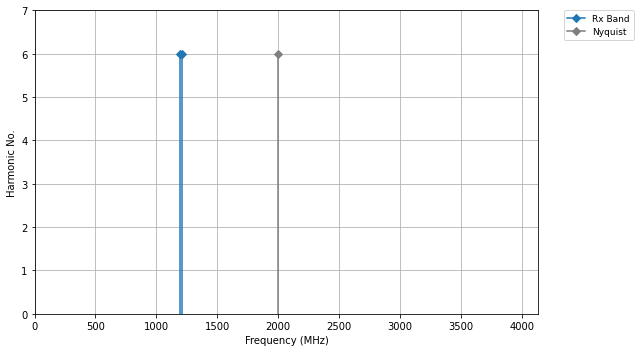

In [107]:
fig_adc = plt.figure(figsize=(9,5))
ax_adc = fig_adc.add_subplot(111)

data_adc = FrequencyPlannerADC(4000, 1200, 20, 409.2, 8)
plot_adc = FrequencyPlannerPlot(fig_adc, ax_adc, data_adc)
plot_adc.update_plot(data_adc)

## RF-DAC

In [129]:
class FrequencyPlannerDAC:
    
    def __init__(self, fs_rf=4092, fc=1175.42, fs_bw=10.23, pll_ref=409.2):
        self.fs_rf = fs_rf
        self.nyq_rf = fs_rf/2
        self.fc = fc
        self.fs_bw = fs_bw
        self.pll_ref = pll_ref

        self.f = np.linspace(-0.5,0.5,101)

    @property
    def signal_f(self):
        fs_rf = self.fs_rf
        fs_bw = self.fs_bw
        fc = self.fc
        f = self.f

        return [fc + (fs_bw*i) for i in f]
    
    @property
    def hd(self):
        nyq_rf = self.nyq_rf
        signal_f = self.signal_f
        
        hd2 = [(i*2 % nyq_rf) if ((int((i*2)/nyq_rf) % 2)  == 0) else (nyq_rf - (i*2 % nyq_rf)) for i in signal_f]
        hd3 = [(i*3 % nyq_rf) if ((int((i*3)/nyq_rf) % 2)  == 0) else (nyq_rf - (i*3 % nyq_rf)) for i in signal_f]
        hd4 = [(i*4 % nyq_rf) if ((int((i*4)/nyq_rf) % 2)  == 0) else (nyq_rf - (i*4 % nyq_rf)) for i in signal_f]
        hd5 = [(i*5 % nyq_rf) if ((int((i*5)/nyq_rf) % 2)  == 0) else (nyq_rf - (i*5 % nyq_rf)) for i in signal_f]
        
        return hd2, hd3, hd4, hd5
    
    @property
    def hd_nyq2(self):
        hd = self.hd
        nyq_rf = self.nyq_rf
        
        hd2 = [2*nyq_rf - i for i in hd[0]]
        hd3 = [2*nyq_rf - i for i in hd[1]]
        hd4 = [2*nyq_rf - i for i in hd[2]]
        hd5 = [2*nyq_rf - i for i in hd[3]]
        
        return hd2, hd3, hd4, hd5
    
    @property
    def fimg(self):
        signal_f = self.signal_f
        nyq_rf = self.nyq_rf
        
        return [(2*nyq_rf - i) if (int(i/nyq_rf) % 2 == 0) else (nyq_rf - (i % nyq_rf)) for i in signal_f]
    
    @property
    def clk_mix_prod(self):
        signal_f = self.signal_f
        fimg = self.fimg
        
        mix_up = [(i + self.pll_ref) for i in signal_f]
        mix_down = [abs(i - self.pll_ref) for i in signal_f]
        mix_up_img = [(i + self.pll_ref) for i in fimg]
        mix_down_img = [abs(i - self.pll_ref) for i in fimg]
        
        return mix_up, mix_down, mix_up_img, mix_down_img

In [130]:
data_dac = FrequencyPlannerDAC(fs_rf=4000, fc=1000, fs_bw=100, pll_ref=500)

In [134]:
min(data_dac.clk_mix_prod[3]), max(data_dac.clk_mix_prod[3])

(2450.0, 2550.0)

## DDC

In [349]:
class FrequencyPlannerDDC:
    def __init__(self, fs_rf=4096, il_factor=8, fc=1024, dec=8, nco=100, hd2_db=70, hd3_db=70, tis_spur_db=70, off_spur_db=70, pll_mix_db=70, pll_ref_db=500, nsd_db=-154):
        self.fs_rf = fs_rf
        self.il_factor = il_factor
        self.fc = fc
        self.dec = dec
        self.nco = nco
        self.hd2_db = hd2_db
        self.hd3_db = hd3_db
        self.tis_spur_db = tis_spur_db
        self.off_spur_db = off_spur_db
        self.pll_mix_db = pll_mix_db
        self.pll_ref_db = pll_ref_db
        self.nsd_db = nsd_db
        
        self.noisefloor = (self.nsd_db + 10*np.log10(self.fs_rf * 10**6 / 2) - 10*np.log10(16384/2))
        
    @property
    def rx_alias(self):
        fs_rf = self.fs_rf
        fc = self.fc
        dec = self.dec
        nco = self.nco
        
        alias_fs = (fs_rf - (fc % fs_rf)) if ((fc % fs_rf) >= fs_rf/2) else (fc % fs_rf) #BE16
        nco_shift = alias_fs + nco #BH16
        
        ax_x = (nco_shift - (nco_shift - fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec)) if nco_shift < 0 else (nco_shift - (nco_shift + fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec)) #BK16
        ax_y = 0
        
        return ax_x, ax_y
    
    @property
    def rx_image(self):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        dec = self.dec
        
        alias_fs = (fs_rf - (fc % fs_rf)) if ((fc % fs_rf) >= fs_rf/2) else (fc % fs_rf) #BE16
        image_fs = fs_rf - alias_fs #BF16
        nco_shift = image_fs + nco #BI16
        
        ax_x = (nco_shift - ((nco_shift - fs_rf/dec/2)//(fs_rf/dec) * fs_rf/dec)) if (nco_shift < 0) else (nco_shift - ((nco_shift + fs_rf/dec/2)//(fs_rf/dec) * fs_rf/dec)) #BL16
        ax_y = 0
        
        return ax_x, ax_y
    
    def __hd(self, hd_num):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        dec = self.dec
        
        alias_fs = (fs_rf - (hd_num*fc % fs_rf)) if (hd_num*fc % fs_rf >= fs_rf/2) else (hd_num*fc % fs_rf) #BE21
        nco_shift = alias_fs + nco #BH21
        
        ax_x = (nco_shift - (nco_shift - fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec)) if (nco_shift < 0) else (nco_shift - (nco_shift + fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec))
        
        return ax_x
    
    def __hd_image(self, hd_num):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        dec = self.dec
        
        alias_fs = (fs_rf - (hd_num*fc % fs_rf)) if (hd_num*fc % fs_rf >= fs_rf/2) else (hd_num*fc % fs_rf) #BE21
        image_fs = fs_rf - alias_fs
        nco_shift = image_fs + nco
        
        ax_x = (nco_shift - (nco_shift - fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec)) if (nco_shift < 0) else (nco_shift - (nco_shift + fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec))
        
        return ax_x
    
    @property
    def hd2(self):
        return (self.__hd(2), -self.hd2_db)
    
    @property
    def hd2_image(self):
        return (self.__hd_image(2), -self.hd2_db)
    
    @property
    def hd3(self):
        return (self.__hd(3), -self.hd3_db)
    
    @property
    def hd3_image(self):
        return (self.__hd_image(3), -self.hd3_db)
    
    @property
    def offset_spur(self):
        fs_rf = self.fs_rf
        il_factor = self.il_factor
        dec = self.dec
        nco = self.nco
        
        alias_fs = (fs_rf/il_factor) if (il_factor==4 or il_factor==6) else (0) #BE26
        nco_shift = alias_fs + nco #BH26
        
        ax_x = 0
        ax_y = -self.off_spur_db
        
        if il_factor==4 or il_factor==8:
            if nco_shift<0:
                ax_x = nco_shift-((nco_shift-fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
            else:
                ax_x = nco_shift-((nco_shift+fs_rf/dec/2)//(fs_rf/dec)*fs_rf/dec)
        else: 
            ax_x = tmp - fs_rf/dec/2
            
        return ax_x, ax_y
    
    @property
    def offset_spur_image(self):
        
        fs_rf = self.fs_rf
        il_factor = self.il_factor
        dec = self.dec
        nco = self.nco
        
        alias_fs = (fs_rf/il_factor) if (il_factor==4 or il_factor==6) else (0) #BE26
        image_fs =  (fs_rf - alias_fs) if (il_factor==4 or il_factor==8) else (0) #BF26
        nco_shift = image_fs - nco
        
        ax_x = 0
        ax_y = -self.off_spur_db
        
        if il_factor==4 or il_factor==8:
            if nco_shift<0:
                ax_x = nco_shift-((nco_shift-fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
            else:
                ax_x = nco_shift-((nco_shift+fs_rf/dec/2)//(fs_rf/dec)*fs_rf/dec)
        else: 
            ax_x = -fs_rf/dec/2
            
        return ax_x, ax_y
    
    @property
    def tis_spur(self):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        il_factor = self.il_factor
        dec = self.dec
        
        alias_fs = (fs_rf - (fc % fs_rf)) if ((fc % fs_rf) >= fs_rf/2) else (fc % fs_rf) #BE16
        
        alias_fs_spur = 0
        
        if il_factor > 1: #BE18
            if (fs_rf/2 - alias_fs) % fs_rf >= fs_rf/2:
                alias_fs_spur = fs_rf - ((fs_rf/2-alias_fs) % fs_rf),
            else:
                alias_fs_spur = (fs_rf/2-alias_fs) % fs_rf
        else:
            alias_fs_spur = 0
            
        nco_shift = alias_fs_spur + nco #BH18
        
        ax_x = 0 #BK18
        
        if il_factor>1:
            if nco_shift < 0:
                ax_x = nco_shift - ((nco_shift-fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
            else:
                ax_x = nco_shift - ((nco_shift+fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
        else:
            ax_x = -fs_rf/dec/2
            
        return ax_x, -self.tis_spur_db
    
    @property
    def tis_spur_image(self):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        il_factor = self.il_factor
        dec = self.dec
        
        alias_fs = (fs_rf - (fc % fs_rf)) if ((fc % fs_rf) >= fs_rf/2) else (fc % fs_rf) #BE16
        
        alias_fs_spur = 0 #BE18
        
        if il_factor > 1:
            if (fs_rf/2 - alias_fs) % fs_rf >= fs_rf/2:
                alias_fs_spur = fs_rf - ((fs_rf/2-alias_fs) % fs_rf),
            else:
                alias_fs_spur = (fs_rf/2-alias_fs) % fs_rf
        else:
            alias_fs_spur = 0
        
        image_fs_spur = (fs_rf - alias_fs_spur) if (il_factor > 1) else (0) #BF18
        
        nco_shift = image_fs_spur + nco #BI18
        
        ax_x = 0 #BL18
        
        if il_factor>1:
            if nco_shift < 0:
                ax_x = nco_shift - ((nco_shift-fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
            else:
                ax_x = nco_shift - ((nco_shift+fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
        else:
            ax_x = -fs_rf/dec/2
            
        return ax_x, -self.tis_spur_db

In [350]:
data_ddc = FrequencyPlannerDDC()

In [351]:
data_ddc.tis_spur_image

(100.0, -70)